In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, f1_score, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression, LinearRegression
from lightgbm import LGBMClassifier, LGBMRegressor

In [67]:
df_train = pd.read_parquet('/home/jupyter/datasphere/project/data/train_dataset_hackaton2023_train.gzip')
df_test = pd.read_parquet('/home/jupyter/datasphere/project/data/hackaton2023_test.gzip')



In [68]:
mapping = pd.read_csv('mapping_2.csv', index_col=0)
df_train['dish_cat'] = df_train.dish_name.map(mapping.to_dict()['dish_category'])
df_test['dish_cat'] = df_test.dish_name.map(mapping.to_dict()['dish_category'])
df_test['date_diff_post'] = 0
df_test['buy_post'] = 0

In [21]:
df_train.head()

,customer_id,date_diff_post,buy_post,group_name,revenue,startdatetime,dish_name,ownareaall_sqm,format_name,dish_cat
0,29891,9.0,1,train,69.99,2022-12-05 12:03:58,Кинг Фри станд,300.0,Отдельно стоящий без внешней зоны,Закуски
1,29891,9.0,1,train,190.00,2022-12-05 12:03:58,Чикен Тар-Тар,300.0,Отдельно стоящий без внешней зоны,Бургер
2,29891,9.0,1,train,9.99,2022-12-05 12:03:58,Соус Сырный,300.0,Отдельно стоящий без внешней зоны,Соус
3,29891,9.0,1,train,119.99,2022-12-05 12:03:58,Энергет.нап. Адреналин Раш,300.0,Отдельно стоящий без внешней зоны,Напитки
4,29891,9.0,1,train,119.99,2022-12-05 14:28:35,Латте (СТАНД.),300.0,Отдельно стоящий без внешней зоны,Напитки


In [26]:
df_train['format_name'].value_counts()

Фудкорт без туалета                              4648951
Отдельно стоящий с внешней зоной                 2310987
Отдельно стоящий без внешней зоны                1814429
Отдельно стоящий                                 1663806
Фудкорт с туалетом                               1166460
Отдельно стоящий без внешней зоны без туалета     268701
Отдельно стоящий без туалета                      164444
Отдельно стоящий с внешн.зоной без туалета         91576
Не заполнено                                          30
Name: format_name, dtype: int64

In [69]:
wc = ['Отдельно стоящий с внешней зоной', 'Отдельно стоящий без внешней зоны', 'Отдельно стоящий', 'Фудкорт с туалетом']
def having_wc(x):
    if x in wc:
        return 1
    else:
        return 0


In [70]:
df_train['having_wc'] = df_train['format_name'].apply(having_wc)
df_test['having_wc'] = df_test['format_name'].apply(having_wc)

In [37]:
df_train

,customer_id,date_diff_post,buy_post,group_name,revenue,startdatetime,dish_name,ownareaall_sqm,format_name,dish_cat,having_wc
0,29891,9.0,1,train,69.99,2022-12-05 12:03:58,Кинг Фри станд,300.0,Отдельно стоящий без внешней зоны,Закуски,1
1,29891,9.0,1,train,190.00,2022-12-05 12:03:58,Чикен Тар-Тар,300.0,Отдельно стоящий без внешней зоны,Бургер,1
2,29891,9.0,1,train,9.99,2022-12-05 12:03:58,Соус Сырный,300.0,Отдельно стоящий без внешней зоны,Соус,1
3,29891,9.0,1,train,119.99,2022-12-05 12:03:58,Энергет.нап. Адреналин Раш,300.0,Отдельно стоящий без внешней зоны,Напитки,1
4,29891,9.0,1,train,119.99,2022-12-05 14:28:35,Латте (СТАНД.),300.0,Отдельно стоящий без внешней зоны,Напитки,1
...,...,...,...,...,...,...,...,...,...,...,...
24261974,46661804,NaN,0,train,7.99,2023-08-01 18:04:56,"Эвервесс Кола джун 0,3л",300.0,Фудкорт с туалетом,Напитки,1
24261975,46661804,NaN,0,train,84.98,2023-08-01 18:04:56,Воппер Джуниор,300.0,Фудкорт с туалетом,Бургер,1
24261976,46661804,NaN,0,train,70.03,2023-08-01 18:04:56,Наггетсы (3 шт.),300.0,Фудкорт с туалетом,Закуски,1
24261977,46661804,NaN,0,train,19.00,2023-08-01 18:04:56,Сырные Медальоны (3 шт.),300.0,Фудкорт с туалетом,Закуски,1


In [114]:
def preprocess(df):
    # df = df.drop_duplicates()
    df['discounts'] = df['revenue'] ==1

    data_check_agg = df.groupby(['customer_id', 'startdatetime']).agg({
        'revenue': 'sum', 
        'buy_post': 'first',
        'date_diff_post': 'first',
        'ownareaall_sqm': 'first',
        'format_name': 'first',
        'discounts': 'sum',
        'having_wc': 'first'
    }).reset_index()

    data_check_agg['delta'] = data_check_agg.groupby('customer_id')['startdatetime'].diff() 
    data_check_agg['delta_hours'] = (data_check_agg['delta'].dt.total_seconds() // (60*60)).fillna(0)
    data_check_agg['delta_days'] = (data_check_agg['delta'].dt.total_seconds() // (24*60*60)).fillna(0)

    data_check_agg = data_check_agg.drop('delta', axis=1)

    data_cust_agg = data_check_agg.groupby('customer_id').agg({
        'revenue': ['mean', 'median', 'std', 'max', 'min', 'count'],
        'delta_hours': ['mean', 'median', 'std', 'max', 'min',], 
        'delta_days': ['mean', 'median', 'std', 'max', 'min',], 
        'startdatetime': ['min', 'max'],
        'ownareaall_sqm': ['mean', 'median', 'std', 'max', 'min',],
        'discounts': ['mean', 'median', 'std', 'max', 'min',],
        'having_wc': 'mean',
        'buy_post': 'first',
        'date_diff_post': 'first',
        'format_name': [pd.Series.mode, 'last']
    }).reset_index()

    data_cust_agg.columns = [f'{header}_{stat}' for header, stat in data_cust_agg.columns]

    data_cust_agg['recency'] = (data_cust_agg['startdatetime_max'] - data_cust_agg['startdatetime_min']).dt.days
    data_cust_agg['T'] = (pd.to_datetime('2023-08-02') - data_cust_agg['startdatetime_min']).dt.days
    data_cust_agg['days_from_last_purchase'] = (pd.to_datetime('2023-08-02') - data_cust_agg['startdatetime_max']).dt.days
    data_cust_agg['lambda'] = data_cust_agg['revenue_count'] / (data_cust_agg['recency'] + 1)
    data_cust_agg['format_name_mode'] = data_cust_agg['format_name_mode'].apply(lambda x: x[0] if type(x)==np.ndarray else x).astype('category')
    data_cust_agg['dish_cat_mode'] = df.groupby('customer_id')['dish_cat'].agg(pd.Series.mode).apply(lambda x: x[0] if type(x)==np.ndarray else x).astype('category').reset_index()['dish_cat']
    data_cust_agg['dish_cat_mode'] = data_cust_agg['dish_cat_mode'].astype('category')
    data_cust_agg['format_name_last'] = data_cust_agg['format_name_last'].astype('category')
    data_cust_agg = data_cust_agg.drop(['startdatetime_min', 'startdatetime_max'], axis=1)
    
    
    
    return data_cust_agg

In [115]:
data_train = preprocess(df_train)

In [116]:
data_test = preprocess(df_test)

In [117]:
X_train = data_train.drop(['date_diff_post_first', 'buy_post_first', 'customer_id_'], axis=1)
y_train_class = data_train['buy_post_first']
y_train_reg = data_train['date_diff_post_first']

# X_valid = data_valid.drop(['date_diff_post_first', 'buy_post_first', 'customer_id_', 'startdatetime_min', 'startdatetime_max'], axis=1)
# y_valid_class = data_valid['buy_post_first']
# y_valid_reg = data_valid['date_diff_post_first']

X_test = data_test.drop(['date_diff_post_first', 'buy_post_first', 'customer_id_'], axis=1)

In [118]:
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
# model = CatBoostClassifier(iterations=5000,
#                         depth=6,
#                         l2_leaf_reg = 3,
#                         leaf_estimation_iterations = 10,
#                         task_type="GPU",
#                         verbose=False,
#                         #cat_features=[26, 27, 32],
#                         class_weights = [0.7, 0.3],
#                         )
model = LGBMClassifier(n_estimators=1000, class_weight={1: 3, 0: 7}, verbose=-1)


In [126]:

res = cross_val_score(model, X_train, y_train_class, scoring='roc_auc')
print(f'ROC-AUC: {res.mean():.3f} ± {res.std():.3f}')

ROC-AUC: 0.747 ± 0.001


In [127]:
model.fit(X_train, y_train_class)

LGBMClassifier(class_weight={0: 7, 1: 3}, n_estimators=1000, verbose=-1)

In [128]:
res = cross_val_score(model, X_train, y_train_class, scoring='f1')
print(f'f1-score: {res.mean():.3f} ± {res.std():.3f}')

f1-score: 0.756 ± 0.012


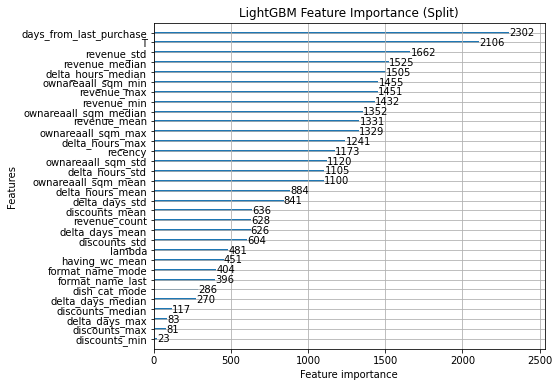

In [129]:
import lightgbm as lgb
lgb.plot_importance(model, importance_type="split", figsize=(7,6), title="LightGBM Feature Importance (Split)")
plt.show()

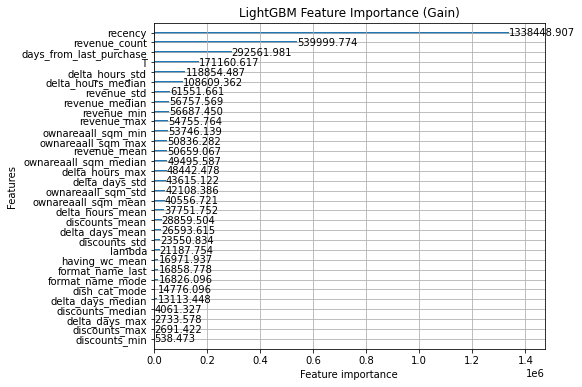

In [130]:
lgb.plot_importance(model, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

In [131]:
X_train

,revenue_mean,revenue_median,revenue_std,revenue_max,revenue_min,revenue_count,delta_hours_mean,delta_hours_median,delta_hours_std,delta_hours_max,delta_hours_min,delta_days_mean,delta_days_median,delta_days_std,delta_days_max,delta_days_min,ownareaall_sqm_mean,ownareaall_sqm_median,ownareaall_sqm_std,ownareaall_sqm_max,ownareaall_sqm_min,discounts_mean,discounts_median,discounts_std,discounts_max,discounts_min,having_wc_mean,format_name_mode,format_name_last,recency,T,days_from_last_purchase,lambda,dish_cat_mode
0,203.494000,199.960,123.170275,439.98,1.00,25,55.240000,24.0,72.502460,266.0,0.0,1.920000,1.0,2.998889,11.0,0.0,449.960000,463.00,45.132656,463.00,300.00,0.120000,0.0,0.331662,1,0,1.000000,Отдельно стоящий с внешней зоной,Отдельно стоящий с внешней зоной,57,239,181,0.431034,Бургер
1,227.024000,229.990,124.933425,499.95,44.99,25,49.400000,23.0,60.578462,216.0,0.0,1.520000,0.0,2.518597,9.0,0.0,320.000000,320.00,0.000000,320.00,320.00,0.240000,0.0,0.663325,2,0,1.000000,Отдельно стоящий без внешней зоны,Отдельно стоящий без внешней зоны,51,301,249,0.480769,Закуски
2,391.399583,344.985,334.849322,1079.97,1.00,24,49.708333,34.5,46.635944,164.0,0.0,1.666667,1.0,1.809796,6.0,0.0,153.000000,153.00,0.000000,153.00,153.00,0.250000,0.0,0.531610,2,0,0.000000,Фудкорт без туалета,Фудкорт без туалета,50,81,31,0.470588,Соус
3,128.725000,59.980,144.471912,344.97,49.97,4,166.750000,11.5,318.351352,644.0,0.0,6.500000,0.0,13.000000,26.0,0.0,126.355000,139.00,25.290000,139.00,88.42,0.000000,0.0,0.000000,0,0,0.000000,Отдельно стоящий без внешней зоны без туалета,Отдельно стоящий без внешней зоны без туалета,27,52,24,0.142857,Десерт
4,554.943333,554.940,49.985000,604.93,504.96,3,123.333333,172.0,107.598017,198.0,0.0,5.000000,7.0,4.358899,8.0,0.0,179.513333,129.27,87.024006,280.00,129.27,2.000000,2.0,0.000000,2,2,0.333333,Фудкорт без туалета,Отдельно стоящий с внешней зоной,15,234,219,0.187500,Закуски
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,311.966667,320.960,207.626131,514.95,99.99,3,9.333333,0.0,16.165808,28.0,0.0,0.333333,0.0,0.577350,1.0,0.0,112.530000,112.53,0.000000,112.53,112.53,0.333333,0.0,0.577350,1,0,0.000000,Фудкорт без туалета,Фудкорт без туалета,1,1,0,1.500000,Закуски
499996,399.956667,349.960,377.456622,799.92,49.99,3,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,120.000000,120.00,0.000000,120.00,120.00,0.000000,0.0,0.000000,0,0,1.000000,Фудкорт с туалетом,Фудкорт с туалетом,0,1,1,3.000000,Соус
499997,363.306667,399.970,177.842347,519.96,169.99,3,1.000000,1.0,1.000000,2.0,0.0,0.000000,0.0,0.000000,0.0,0.0,80.200000,80.20,0.000000,80.20,80.20,1.000000,1.0,0.000000,1,1,0.000000,Фудкорт без туалета,Фудкорт без туалета,0,1,1,3.000000,Напитки
499998,406.643333,469.960,202.558140,569.98,179.99,3,1.666667,1.0,2.081666,4.0,0.0,0.000000,0.0,0.000000,0.0,0.0,270.000000,270.00,0.000000,270.00,270.00,0.000000,0.0,0.000000,0,0,1.000000,Отдельно стоящий с внешней зоной,Отдельно стоящий с внешней зоной,0,0,0,3.000000,Напитки


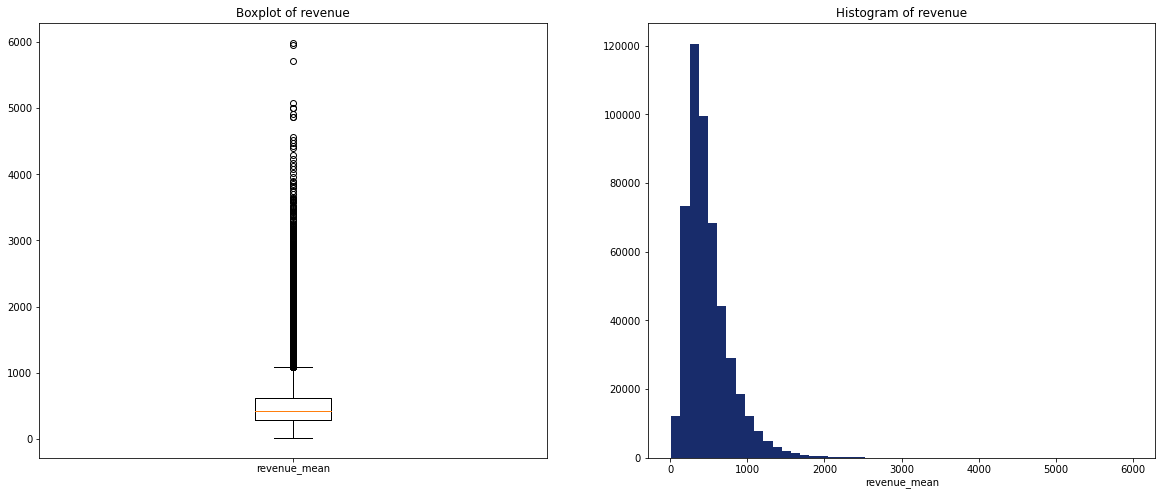

In [132]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
axes[0].set_title('Boxplot of revenue')
labels = ['revenue_mean']
axes[0].boxplot(X_train['revenue_mean'], labels=labels)

axes[1].set_title('Histogram of revenue')

axes[1].hist(X_train['revenue_mean'], bins=50, label = 'revenue_mean', color = '#182c6bff')
axes[1].set_xlabel('revenue_mean')

plt.show()

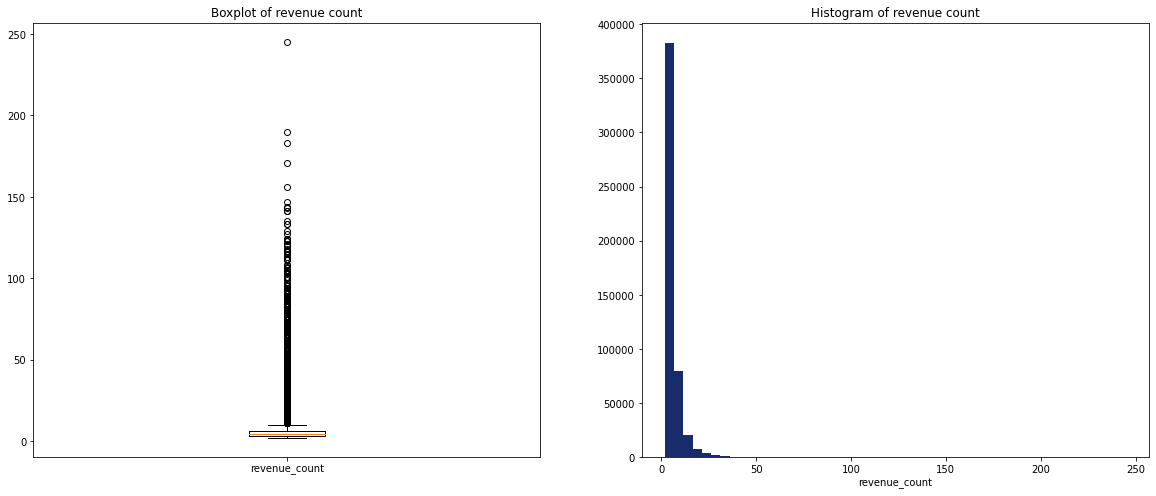

In [136]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
axes[0].set_title('Boxplot of revenue count')
labels = ['revenue_count']
axes[0].boxplot(X_train['revenue_count'], labels=labels)

axes[1].set_title('Histogram of revenue count')

axes[1].hist(X_train['revenue_count'], bins=50, label = 'revenue_count', color = '#182c6bff')
axes[1].set_xlabel('revenue_count')

plt.show()

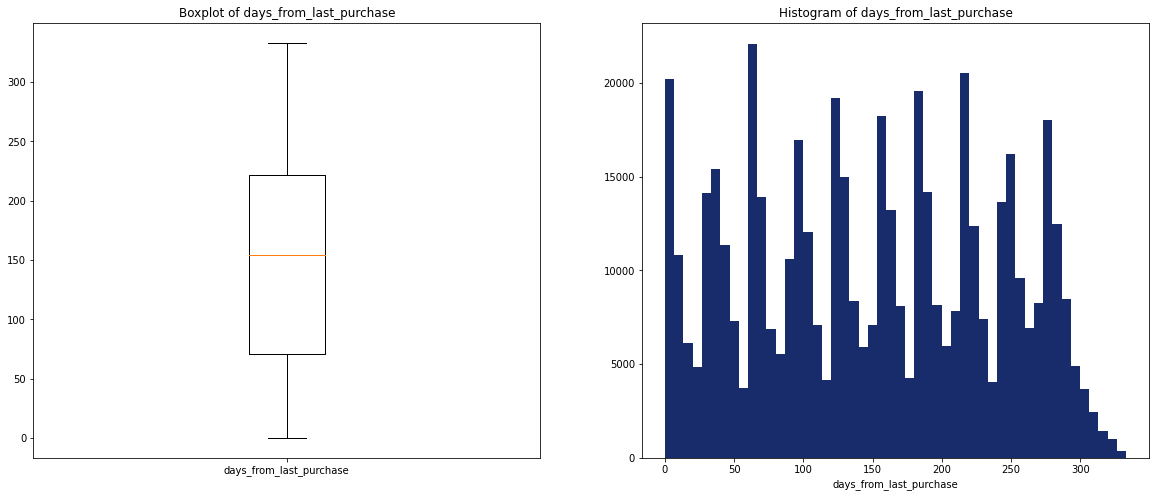

In [138]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
axes[0].set_title('Boxplot of days_from_last_purchase')
labels = ['days_from_last_purchase']
axes[0].boxplot(X_train['days_from_last_purchase'], labels=labels)

axes[1].set_title('Histogram of days_from_last_purchase')

axes[1].hist(X_train['days_from_last_purchase'], bins=50, label = 'days_from_last_purchase', color = '#182c6bff')
axes[1].set_xlabel('days_from_last_purchase')

plt.show()

In [137]:
X_train.columns

Index(['revenue_mean', 'revenue_median', 'revenue_std', 'revenue_max',
       'revenue_min', 'revenue_count', 'delta_hours_mean',
       'delta_hours_median', 'delta_hours_std', 'delta_hours_max',
       'delta_hours_min', 'delta_days_mean', 'delta_days_median',
       'delta_days_std', 'delta_days_max', 'delta_days_min',
       'ownareaall_sqm_mean', 'ownareaall_sqm_median', 'ownareaall_sqm_std',
       'ownareaall_sqm_max', 'ownareaall_sqm_min', 'discounts_mean',
       'discounts_median', 'discounts_std', 'discounts_max', 'discounts_min',
       'having_wc_mean', 'format_name_mode', 'format_name_last', 'recency',
       'T', 'days_from_last_purchase', 'lambda', 'dish_cat_mode'],
      dtype='object')

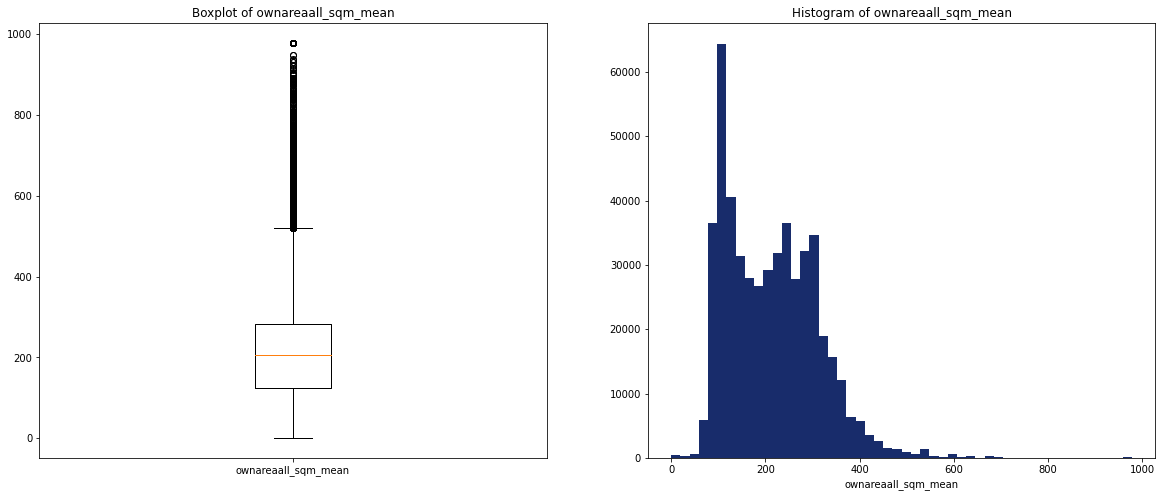

In [139]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
axes[0].set_title('Boxplot of ownareaall_sqm_mean')
labels = ['ownareaall_sqm_mean']
axes[0].boxplot(X_train['ownareaall_sqm_mean'], labels=labels)

axes[1].set_title('Histogram of ownareaall_sqm_mean')

axes[1].hist(X_train['ownareaall_sqm_mean'], bins=50, label = 'ownareaall_sqm_mean', color = '#182c6bff')
axes[1].set_xlabel('ownareaall_sqm_mean')

plt.show()

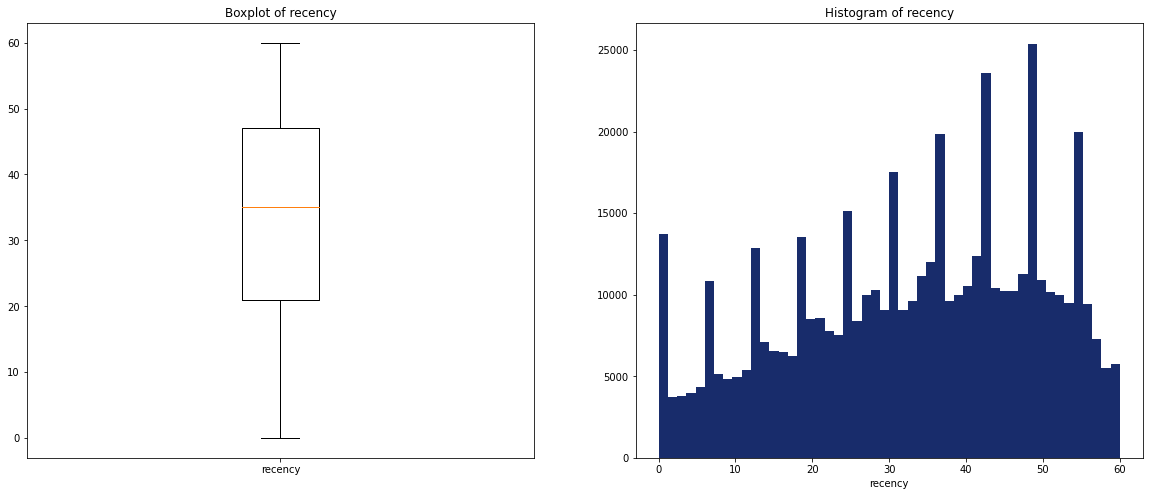

In [140]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
axes[0].set_title('Boxplot of recency')
labels = ['recency']
axes[0].boxplot(X_train['recency'], labels=labels)

axes[1].set_title('Histogram of recency')

axes[1].hist(X_train['recency'], bins=50, label = 'recency', color = '#182c6bff')
axes[1].set_xlabel('recency')

plt.show()